# **Single-Cell RNA-Seq Analysis Project: Advanced Deep Learning**

In this project, we apply deep learning techniques (Autoencoders, VAEs, GANs) to the `norman` dataset.

Choose one of the following tasks:

**Exploratory Data Analysis and Visualization**

- Objective: Explore the dataset to identify patterns and clusters.
- Tasks:
  - Perform dimensionality reduction using PCA, t-SNE, or UMAP.
  - Visualize gene expression profiles across different conditions or perturbations.
  - Create heatmaps of the top differentially expressed genes.
- Learning Outcomes:
  - Learn to visualize high-dimensional data.
  - Interpret clusters and patterns in the context of biological conditions.

**Machine Learning Classification**

- Objective: Build models to classify samples based on gene expression profiles.
- Tasks:
  - Split the dataset into training and testing sets.
  - Implement classification algorithms.
  - Evaluate model performance using metrics like accuracy, precision, recall, and ROC curves.
- Learning Outcomes:
  - Understand supervised learning techniques.
  - Learn model evaluation and validation strategies.

**Advanced Deep Learning Applications**

- Objective: Apply deep learning techniques to model complex patterns in the data.
- Tasks:
  - Implement autoencoders or variational autoencoders for dimensionality reduction.
  - Explore the use of GANs to generate synthetic gene expression data.
  - Analyze how deep learning models capture nonlinear relationships.
- Learning Outcomes:
  - Gain experience with deep learning frameworks.
  - Understand the applications of deep learning in genomics.

In [1]:
import os
import sys

# Append the root of the Git repository to the path.
git_root = os.popen(cmd="git rev-parse --show-toplevel").read().strip()
sys.path.append(git_root)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from perturbation_data_analysis import pertdata as pt
import models
import data_utils
import evaluation
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
# Load the dataset
norman = pt.PertDataset(name="norman", cache_dir_path="data", silent=False)

print(norman)


/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset already downloaded at /Users/amirrezaalasti/Desktop/master/semester 3/MLGenomic/amlg/src/projects/scrnaseq_project/data/norman
Loading: /Users/amirrezaalasti/Desktop/master/semester 3/MLGenomic/amlg/src/projects/scrnaseq_project/data/norman/norman/perturb_processed.h5ad
PertDataset object
    name: norman
    cache_dir_path: /Users/amirrezaalasti/Desktop/master/semester 3/MLGenomic/amlg/src/projects/scrnaseq_project/data
    path: /Users/amirrezaalasti/Desktop/master/semester 3/MLGenomic/amlg/src/projects/scrnaseq_project/data/norman
    adata: AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'


## 1. Data Preprocessing

- Fix perturbation labels
- Filter single-gene perturbations
- Select top 1000 high-variance genes

In [2]:
# Preprocess data using utility functions
d = 1000
adata_single_top_genes = data_utils.preprocess_data(norman.adata, n_genes=d)

print(f"Selected {d} genes with highest variance.")
print(f"New shape: {adata_single_top_genes.shape}")

Selected 1000 genes with highest variance.
New shape: (55760, 1000)


## 2. Train/Test Split

Convert to PyTorch tensors and create DataLoaders.

In [3]:
# Convert to PyTorch tensor and create dataloaders
from sklearn.preprocessing import StandardScaler

# Log-transform and scale data
X_raw = adata_single_top_genes.X.toarray()
X_log = np.log1p(X_raw)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

X = torch.tensor(data=X_scaled, dtype=torch.float32)

batch_size = 128
train_loader, val_loader, test_loader = data_utils.create_dataloaders(
    X, batch_size=batch_size, train_ratio=0.7, val_ratio=0.15, seed=42
)

# Get dataset sizes for reporting
train_dataset = train_loader.dataset
val_dataset = val_loader.dataset
test_dataset = test_loader.dataset

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 39032, Val samples: 8364, Test samples: 8364


## 3. Improved Autoencoder (AE)

We use an improved Autoencoder with deeper architecture, dropout, batch normalization, and proper validation to learn a low-dimensional representation of the gene expression data.

In [4]:
feature_dim = X.shape[1]

In [5]:
# Create and train Autoencoder
autoencoder = models.Autoencoder(in_features=feature_dim, latent_dim=64, learning_rate=1e-3)

early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True)
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="best-{epoch:02d}-{val_loss:.4f}")

logger_ae = CSVLogger(save_dir="lightning_logs", name="ae_experiment")
trainer_ae = pl.Trainer(
    max_epochs=50, 
    logger=logger_ae, 
    accelerator="auto",
    devices="auto",
    callbacks=[early_stop, checkpoint],
    enable_progress_bar=True
)
trainer_ae.fit(model=autoencoder, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 298 K  | train
1 | decoder | Decoder | 299 K  | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
597 K     Trainable params
0         Non-trainable params
597 K     Total params
2.389     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 305/305 [00:10<00:00, 30.07it/s, v_num=0, val_loss=0.904, train_loss=0.951]

Metric val_loss improved. New best score: 0.904


Epoch 1: 100%|██████████| 305/305 [00:07<00:00, 43.29it/s, v_num=0, val_loss=0.891, train_loss=0.911]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.891


Epoch 2: 100%|██████████| 305/305 [00:07<00:00, 42.82it/s, v_num=0, val_loss=0.883, train_loss=0.901]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.883


Epoch 3: 100%|██████████| 305/305 [00:07<00:00, 42.74it/s, v_num=0, val_loss=0.878, train_loss=0.895]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.878


Epoch 4: 100%|██████████| 305/305 [00:06<00:00, 44.46it/s, v_num=0, val_loss=0.876, train_loss=0.891]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.876


Epoch 5: 100%|██████████| 305/305 [00:07<00:00, 39.97it/s, v_num=0, val_loss=0.873, train_loss=0.888]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.873


Epoch 6: 100%|██████████| 305/305 [00:07<00:00, 40.64it/s, v_num=0, val_loss=0.871, train_loss=0.886]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.871


Epoch 7: 100%|██████████| 305/305 [00:07<00:00, 42.44it/s, v_num=0, val_loss=0.870, train_loss=0.884]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.870


Epoch 8: 100%|██████████| 305/305 [00:06<00:00, 43.67it/s, v_num=0, val_loss=0.869, train_loss=0.883]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.869


Epoch 9: 100%|██████████| 305/305 [00:06<00:00, 46.71it/s, v_num=0, val_loss=0.867, train_loss=0.882]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.867


Epoch 10: 100%|██████████| 305/305 [00:06<00:00, 45.30it/s, v_num=0, val_loss=0.866, train_loss=0.881]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.866


Epoch 12: 100%|██████████| 305/305 [00:06<00:00, 47.06it/s, v_num=0, val_loss=0.866, train_loss=0.879]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.866


Epoch 13: 100%|██████████| 305/305 [00:08<00:00, 37.59it/s, v_num=0, val_loss=0.864, train_loss=0.879]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.864


Epoch 14: 100%|██████████| 305/305 [00:06<00:00, 45.75it/s, v_num=0, val_loss=0.864, train_loss=0.878]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.864


Epoch 15: 100%|██████████| 305/305 [00:06<00:00, 47.13it/s, v_num=0, val_loss=0.863, train_loss=0.878]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.863


Epoch 16: 100%|██████████| 305/305 [00:06<00:00, 48.13it/s, v_num=0, val_loss=0.863, train_loss=0.877]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.863


Epoch 18: 100%|██████████| 305/305 [00:06<00:00, 46.24it/s, v_num=0, val_loss=0.862, train_loss=0.877]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.862


Epoch 19: 100%|██████████| 305/305 [00:06<00:00, 45.87it/s, v_num=0, val_loss=0.862, train_loss=0.876]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.862


Epoch 20: 100%|██████████| 305/305 [00:08<00:00, 36.31it/s, v_num=0, val_loss=0.861, train_loss=0.876]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.861


Epoch 21: 100%|██████████| 305/305 [00:08<00:00, 36.61it/s, v_num=0, val_loss=0.861, train_loss=0.876]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.861


Epoch 22: 100%|██████████| 305/305 [00:07<00:00, 42.63it/s, v_num=0, val_loss=0.861, train_loss=0.875]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.861


Epoch 23: 100%|██████████| 305/305 [00:06<00:00, 47.56it/s, v_num=0, val_loss=0.860, train_loss=0.875]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.860


Epoch 24: 100%|██████████| 305/305 [00:06<00:00, 47.64it/s, v_num=0, val_loss=0.859, train_loss=0.874]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.859


Epoch 27: 100%|██████████| 305/305 [00:06<00:00, 47.28it/s, v_num=0, val_loss=0.859, train_loss=0.874]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.859


Epoch 28: 100%|██████████| 305/305 [00:07<00:00, 41.82it/s, v_num=0, val_loss=0.858, train_loss=0.874]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.858


Epoch 32: 100%|██████████| 305/305 [00:06<00:00, 44.80it/s, v_num=0, val_loss=0.858, train_loss=0.873]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.858


Epoch 33: 100%|██████████| 305/305 [00:06<00:00, 44.97it/s, v_num=0, val_loss=0.858, train_loss=0.873]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.858


Epoch 34: 100%|██████████| 305/305 [00:07<00:00, 39.03it/s, v_num=0, val_loss=0.857, train_loss=0.872]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.857


Epoch 35: 100%|██████████| 305/305 [00:09<00:00, 32.59it/s, v_num=0, val_loss=0.857, train_loss=0.872]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.857


Epoch 36: 100%|██████████| 305/305 [00:07<00:00, 42.92it/s, v_num=0, val_loss=0.857, train_loss=0.872]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.857


Epoch 38: 100%|██████████| 305/305 [00:07<00:00, 38.61it/s, v_num=0, val_loss=0.857, train_loss=0.872]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.857


Epoch 39: 100%|██████████| 305/305 [00:07<00:00, 40.10it/s, v_num=0, val_loss=0.857, train_loss=0.872]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.857


Epoch 40: 100%|██████████| 305/305 [00:09<00:00, 30.84it/s, v_num=0, val_loss=0.856, train_loss=0.872]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.856


Epoch 41: 100%|██████████| 305/305 [00:09<00:00, 31.91it/s, v_num=0, val_loss=0.856, train_loss=0.871]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.856


Epoch 42: 100%|██████████| 305/305 [00:06<00:00, 46.27it/s, v_num=0, val_loss=0.856, train_loss=0.871]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.856


Epoch 44: 100%|██████████| 305/305 [00:07<00:00, 42.98it/s, v_num=0, val_loss=0.855, train_loss=0.871]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.855


Epoch 47: 100%|██████████| 305/305 [00:08<00:00, 37.00it/s, v_num=0, val_loss=0.855, train_loss=0.871]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.855


Epoch 48: 100%|██████████| 305/305 [00:07<00:00, 42.11it/s, v_num=0, val_loss=0.855, train_loss=0.870]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.855


Epoch 49: 100%|██████████| 305/305 [00:06<00:00, 50.80it/s, v_num=0, val_loss=0.855, train_loss=0.870]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 305/305 [00:06<00:00, 50.76it/s, v_num=0, val_loss=0.855, train_loss=0.870]


## 4. Improved Variational Autoencoder (VAE)

We implement an improved VAE with better architecture, KL annealing, and proper validation to learn a smooth latent space, which is better for generative tasks.

In [ ]:
vae = models.VAE(in_features=feature_dim, latent_dim=64, learning_rate=1e-3, 
                  kl_weight=0.1, kl_annealing=True)

early_stop_vae = EarlyStopping(monitor="val_loss", patience=5, mode="min")
checkpoint_vae = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, 
                                 filename="best-{epoch:02d}-{val_loss:.4f}")

logger_vae = CSVLogger(save_dir="lightning_logs", name="vae_experiment")
trainer_vae = pl.Trainer(
    max_epochs=50, 
    logger=logger_vae, 
    accelerator="auto",
    devices="auto",
    callbacks=[early_stop_vae, checkpoint_vae],
    enable_progress_bar=True
)
trainer_vae.fit(model=vae, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 289 K  | train
1 | fc_mu   | Linear     | 8.3 K  | train
2 | fc_var  | Linear     | 8.3 K  | train
3 | decoder | Sequential | 299 K  | train
-----------------------------------------------
605 K     Trainable params
0         Non-trainable params
605 K     Total params
2.422     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 49: 100%|██████████| 305/305 [00:07<00:00, 40.87it/s, v_num=0, val_loss=0.944, train_loss=0.948, recon_loss=0.924, kl_loss=0.0494]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 305/305 [00:07<00:00, 40.82it/s, v_num=0, val_loss=0.944, train_loss=0.948, recon_loss=0.924, kl_loss=0.0494]


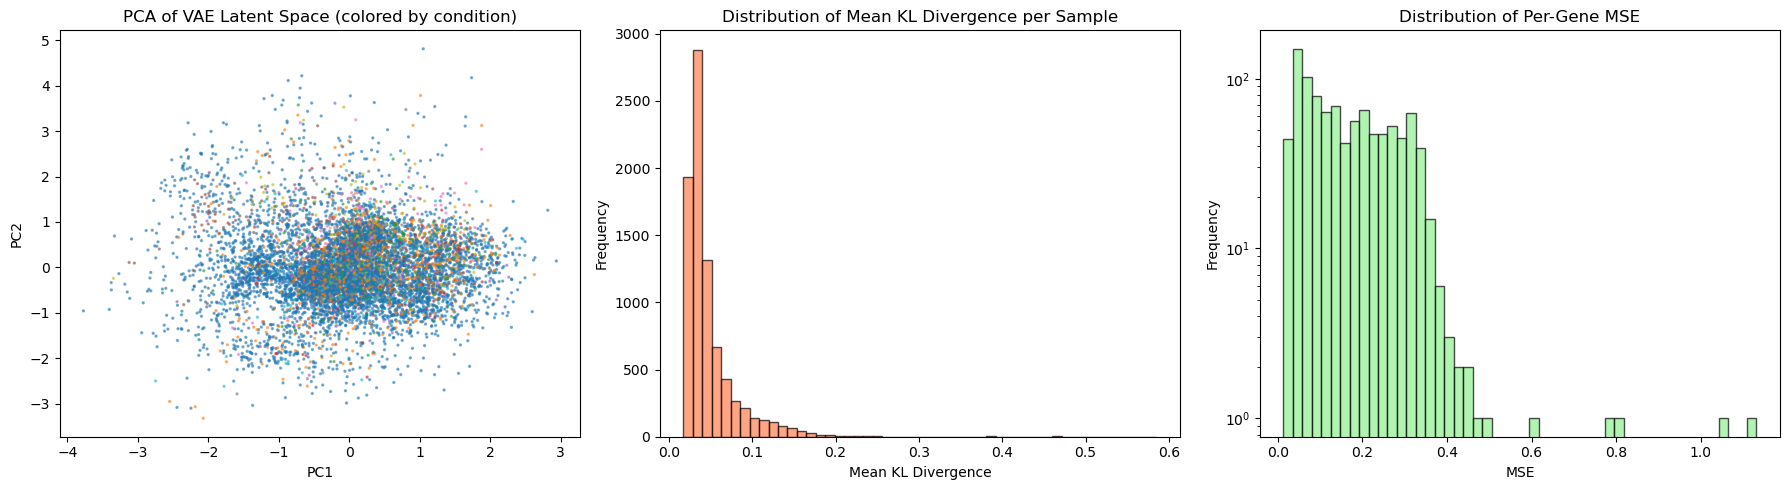


VAE Evaluation Statistics:
Overall MSE: 0.1678
Overall MAE: 0.2843
Mean KL Divergence: 0.0482 ± 0.2917
Mean per-gene MSE: 0.1678 ± 0.1149


In [8]:
vae.eval()
with torch.no_grad():
    X_test_tensor = test_dataset.dataset.tensors[0][test_dataset.indices]
    mu, log_var = vae.encode(X_test_tensor)
    z = mu.numpy()
    reconstructed_norm, _, _ = vae(X_test_tensor)
    reconstructed_norm_np = reconstructed_norm.numpy()
    X_test_norm = X_test_tensor.numpy()

# Inverse transform to original count space for evaluation
X_test_np = np.expm1(scaler.inverse_transform(X_test_norm))
reconstructed_np = np.expm1(scaler.inverse_transform(reconstructed_norm_np))
X_test_np = np.maximum(X_test_np, 0)
reconstructed_np = np.maximum(reconstructed_np, 0)

test_indices = test_dataset.indices
conditions = adata_single_top_genes.obs["condition_fixed"].iloc[test_indices].values
unique_conditions = pd.Series(conditions).value_counts().head(10).index
condition_to_color = {cond: i for i, cond in enumerate(unique_conditions)}
colors = [condition_to_color.get(cond, -1) for cond in conditions]

pca_vae = PCA(n_components=2)
z_pca = pca_vae.fit_transform(z)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(z_pca[:, 0], z_pca[:, 1], c=colors, cmap='tab10', alpha=0.5, s=2)
axes[0].set_title('PCA of VAE Latent Space (colored by condition)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

kl_div = -0.5 * (1 + log_var.numpy() - mu.numpy()**2 - np.exp(log_var.numpy()))
kl_mean_per_sample = kl_div.mean(axis=1)
axes[1].hist(kl_mean_per_sample, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Mean KL Divergence per Sample')
axes[1].set_xlabel('Mean KL Divergence')
axes[1].set_ylabel('Frequency')

mse_per_gene = mean_squared_error(X_test_np, reconstructed_np, multioutput='raw_values')
axes[2].hist(mse_per_gene, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].set_title('Distribution of Per-Gene MSE')
axes[2].set_xlabel('MSE')
axes[2].set_ylabel('Frequency')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\nVAE Evaluation Statistics:")
print(f"Overall MSE: {mean_squared_error(X_test_np, reconstructed_np):.4f}")
print(f"Overall MAE: {mean_absolute_error(X_test_np, reconstructed_np):.4f}")
print(f"Mean KL Divergence: {kl_div.mean():.4f} ± {kl_div.std():.4f}")
print(f"Mean per-gene MSE: {mse_per_gene.mean():.4f} ± {mse_per_gene.std():.4f}")

## 5. Improved Generative Adversarial Network (GAN)

We implement an improved GAN with better architecture, gradient penalty (WGAN-GP style), and proper validation to generate synthetic gene expression profiles that mimic the real data.

In [5]:
gan = models.GAN(in_features=feature_dim, latent_dim=64, learning_rate=2e-4, n_discriminator_steps=2)

checkpoint_gan = ModelCheckpoint(monitor="val_d_loss", mode="min", save_top_k=1, 
                                 filename="best-{epoch:02d}-{val_d_loss:.4f}")

logger_gan = CSVLogger(save_dir="lightning_logs", name="gan_experiment")
trainer_gan = pl.Trainer(
    max_epochs=100,
    logger=logger_gan, 
    accelerator="auto",
    devices="auto",
    callbacks=[checkpoint_gan],
    enable_progress_bar=True
)
trainer_gan.fit(model=gan, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 686 K  | train
1 | discriminator | Discriminator | 676 K  | train
--------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.455     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 99: 100%|██████████| 305/305 [00:17<00:00, 16.96it/s, v_num=2, val_d_loss=0.0846, val_g_loss=3.840, g_loss=3.860, d_loss=0.262]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 305/305 [00:17<00:00, 16.95it/s, v_num=2, val_d_loss=0.0846, val_g_loss=3.840, g_loss=3.860, d_loss=0.262]


Model loaded successfully!

Generated 8364 synthetic samples
Real data shape: (8364, 1000), Synthetic data shape: (8364, 1000)


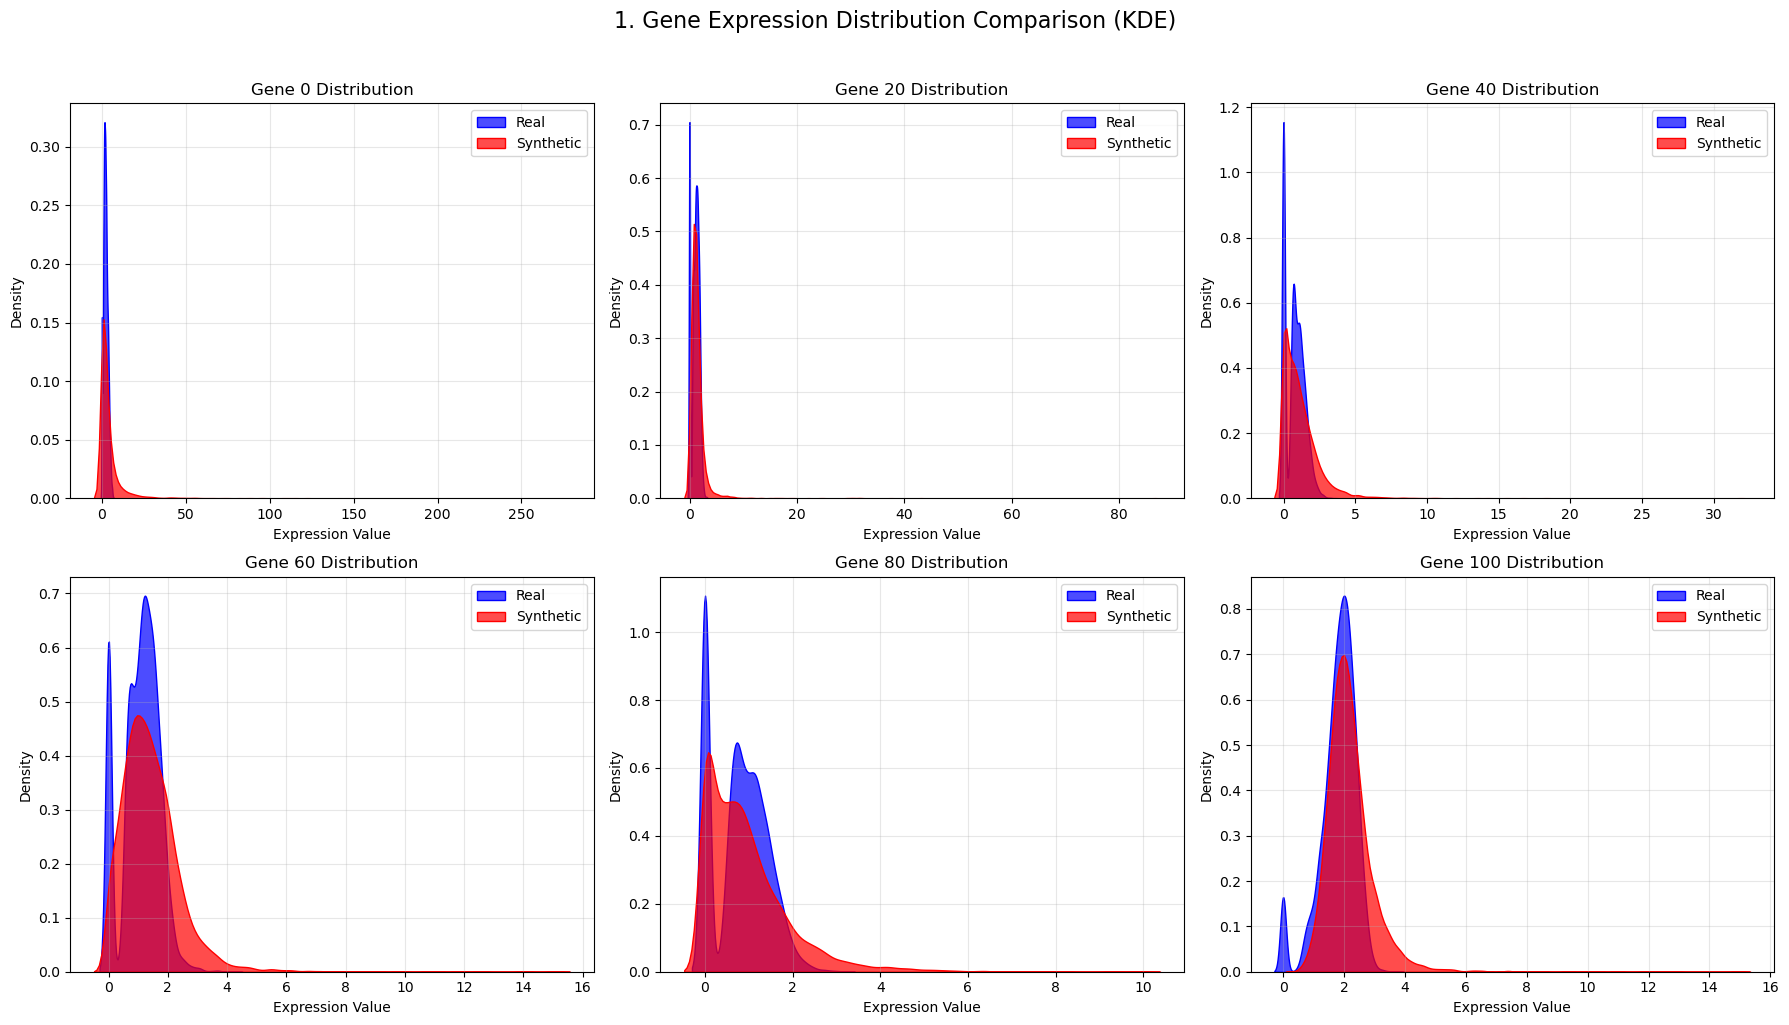


GAN Generation Statistics:
Real data mean: 0.5256 ± 0.8809
Synthetic data mean: 0.6283 ± 1.2371
Real data min/max: [0.0000, 8.4830]
Synthetic data min/max: [0.0000, 1076.8357]

Correlation between real and synthetic gene means: 0.9805 (p=0.00e+00)


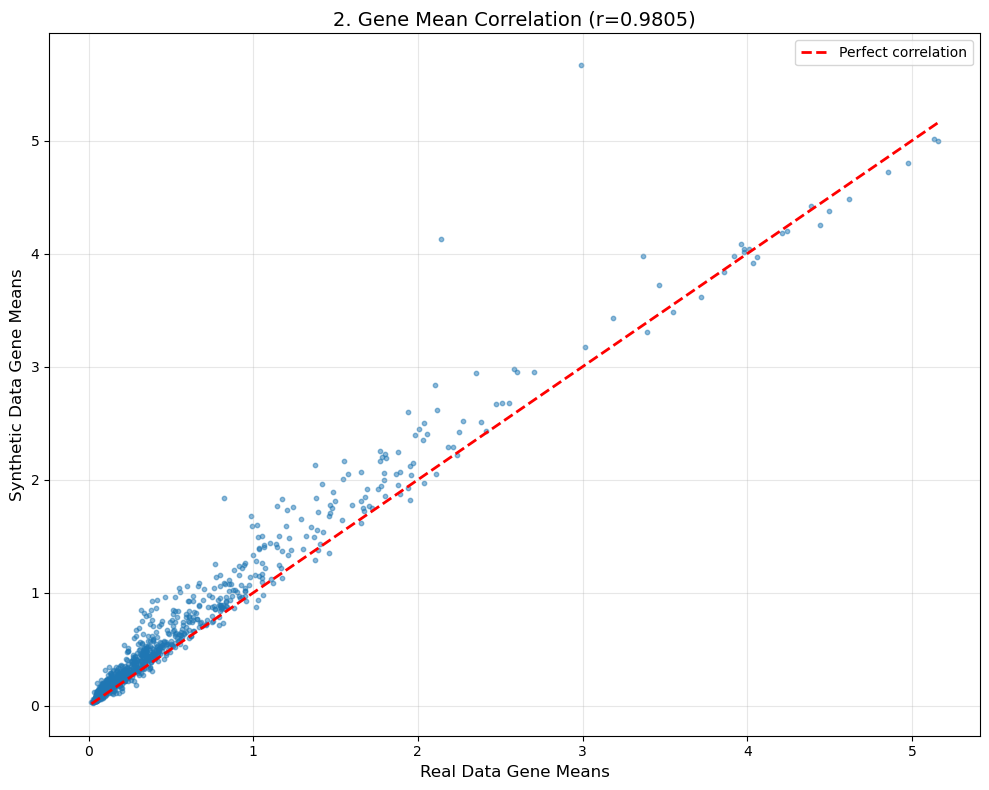

In [15]:
# Load the trained GAN model from checkpoint
# checkpoint_path = "/Users/amirrezaalasti/Desktop/master/semester 3/MLGenomic/amlg/src/projects/scrnaseq_project/lightning_logs/gan_experiment/version_7/checkpoints/best-epoch=99-val_d_loss=0.3495.ckpt"
# print(f"Loading GAN model from checkpoint: {checkpoint_path}")

# Load the model with the correct hyperparameters
# gan = models.GAN.load_from_checkpoint(checkpoint_path)
gan.eval()
print("Model loaded successfully!")

# Generate synthetic data using utility function
n_samples = len(test_dataset)
synthetic_data = evaluation.generate_synthetic_data(gan, n_samples, latent_dim=64)

X_test_tensor = test_dataset.dataset.tensors[0][test_dataset.indices]
# Inverse transform to get original counts for proper evaluation
real_data_norm = X_test_tensor.numpy()
synthetic_data_norm = synthetic_data

# Inverse scale then inverse log1p (exp(x) - 1)
real_data = np.expm1(scaler.inverse_transform(real_data_norm))
synthetic_data = np.expm1(scaler.inverse_transform(synthetic_data_norm))

# Clip negative values that might result from numerical instability
real_data = np.maximum(real_data, 0)
synthetic_data = np.maximum(synthetic_data, 0)

print(f"\nGenerated {n_samples} synthetic samples")
print(f"Real data shape: {real_data.shape}, Synthetic data shape: {synthetic_data.shape}")

# ============================================================================
# 1. Gene Distribution Comparison (KDE plots)
# ============================================================================
n_genes_to_plot = 6
gene_indices = np.linspace(0, min(100, feature_dim-1), n_genes_to_plot, dtype=int)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, gene_idx in enumerate(gene_indices):
    sns.kdeplot(real_data[:, gene_idx], label='Real', fill=True, ax=axes[i], alpha=0.7, color='blue')
    sns.kdeplot(synthetic_data[:, gene_idx], label='Synthetic', fill=True, ax=axes[i], alpha=0.7, color='red')
    axes[i].set_title(f'Gene {gene_idx} Distribution')
    axes[i].set_xlabel('Expression Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('1. Gene Expression Distribution Comparison (KDE)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# 2. Overall Statistics Comparison
# ============================================================================
print("\n" + "="*70)
print("GAN Generation Statistics:")
print("="*70)
print(f"Real data mean: {real_data.mean():.4f} ± {real_data.std():.4f}")
print(f"Synthetic data mean: {synthetic_data.mean():.4f} ± {synthetic_data.std():.4f}")
print(f"Real data min/max: [{real_data.min():.4f}, {real_data.max():.4f}]")
print(f"Synthetic data min/max: [{synthetic_data.min():.4f}, {synthetic_data.max():.4f}]")

real_means = real_data.mean(axis=0)
synth_means = synthetic_data.mean(axis=0)
correlation, p_value = pearsonr(real_means, synth_means)
print(f"\nCorrelation between real and synthetic gene means: {correlation:.4f} (p={p_value:.2e})")

# ============================================================================
# 3. Gene Mean Correlation Scatter Plot
# ============================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(real_means, synth_means, alpha=0.5, s=10)
ax.plot([real_means.min(), real_means.max()], [real_means.min(), real_means.max()], 
        'r--', lw=2, label='Perfect correlation')
ax.set_xlabel('Real Data Gene Means', fontsize=12)
ax.set_ylabel('Synthetic Data Gene Means', fontsize=12)
ax.set_title(f'2. Gene Mean Correlation (r={correlation:.4f})', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Comprehensive Evaluation and Visualization

We evaluate the quality of all models by visualizing the latent spaces, computing comprehensive reconstruction metrics, and comparing model performances.

In [11]:
# Final model testing on test set
print("\n" + "="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)

# Load models from checkpoints
import os
from pathlib import Path
import pytorch_lightning as pl

base_path = Path("lightning_logs")

# Load Autoencoder
print("\nLoading Autoencoder from checkpoint...")
ae_checkpoint = base_path / "ae_experiment" / "version_0" / "checkpoints" / "best-epoch=48-val_loss=0.8545.ckpt"
autoencoder = models.Autoencoder.load_from_checkpoint(str(ae_checkpoint))
print(f"✓ Autoencoder loaded from: {ae_checkpoint}")

# Load VAE
print("\nLoading VAE from checkpoint...")
vae_checkpoint = base_path / "vae_experiment" / "version_0" / "checkpoints" / "best-epoch=47-val_loss=0.9439.ckpt"
vae = models.VAE.load_from_checkpoint(str(vae_checkpoint))
print(f"✓ VAE loaded from: {vae_checkpoint}")

# Load GAN - Note: version_0 doesn't have a checkpoint, using version_2 instead
print("\nLoading GAN from checkpoint...")
gan_checkpoint = base_path / "gan_experiment" / "version_2" / "checkpoints" / "best-epoch=94-val_d_loss=0.0773.ckpt"
# Check if version_0 has checkpoint
if (base_path / "gan_experiment" / "version_0" / "checkpoints").exists():
    gan_checkpoints = list((base_path / "gan_experiment" / "version_0" / "checkpoints").glob("*.ckpt"))
    if gan_checkpoints:
        gan_checkpoint = gan_checkpoints[0]
        print(f"✓ Found GAN checkpoint in version_0: {gan_checkpoint}")
    else:
        print(f"⚠ GAN version_0 has no checkpoint, using version_2: {gan_checkpoint}")
else:
    print(f"⚠ GAN version_0 has no checkpoints directory, using version_2: {gan_checkpoint}")

gan = models.GAN.load_from_checkpoint(str(gan_checkpoint))
print(f"✓ GAN loaded from: {gan_checkpoint}")

# Create trainers for testing
print("\n" + "="*60)
print("Creating trainers...")
print("="*60)

trainer_ae = pl.Trainer(
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    logger=False  # Disable logging for test
)

trainer_vae = pl.Trainer(
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    logger=False  # Disable logging for test
)

trainer_gan = pl.Trainer(
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    logger=False  # Disable logging for test
)

print("✓ Trainers created")

# Test all models
print("\n" + "="*60)
print("Testing models on test set...")
print("="*60)

print("\nTesting Autoencoder on test set...")
trainer_ae.test(model=autoencoder, dataloaders=test_loader)

print("\nTesting VAE on test set...")
trainer_vae.test(model=vae, dataloaders=test_loader)

print("\nTesting GAN on test set...")
trainer_gan.test(model=gan, dataloaders=test_loader)

print("\n" + "="*60)
print("All models have been evaluated!")
print("="*60)


FINAL TEST SET EVALUATION

Loading Autoencoder from checkpoint...
✓ Autoencoder loaded from: lightning_logs/ae_experiment/version_0/checkpoints/best-epoch=48-val_loss=0.8545.ckpt

Loading VAE from checkpoint...
✓ VAE loaded from: lightning_logs/vae_experiment/version_0/checkpoints/best-epoch=47-val_loss=0.9439.ckpt

Loading GAN from checkpoint...
⚠ GAN version_0 has no checkpoints directory, using version_2: lightning_logs/gan_experiment/version_2/checkpoints/best-epoch=94-val_d_loss=0.0773.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


✓ GAN loaded from: lightning_logs/gan_experiment/version_2/checkpoints/best-epoch=94-val_d_loss=0.0773.ckpt

Creating trainers...
✓ Trainers created

Testing models on test set...

Testing Autoencoder on test set...


/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 123.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8532861471176147     │
└───────────────────────────┴───────────────────────────┘


Testing VAE on test set...
Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 195.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_kl_loss        │    0.04848666489124298    │
│         test_loss         │    0.9418050646781921     │
│      test_recon_loss      │     0.917561411857605     │
└───────────────────────────┴───────────────────────────┘


Testing GAN on test set...
Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 114.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_d_loss        │    0.07748233526945114    │
│        test_g_loss        │     3.760861396789551     │
└───────────────────────────┴───────────────────────────┘


All models have been evaluated!



RE-EVALUATING LOADED MODELS

Evaluating Autoencoder...
  ✓ Applying inverse transformation (expm1 + inverse scaling)

Evaluating VAE...
  ✓ Applying inverse transformation (expm1 + inverse scaling)

Evaluation complete! Results ready for visualization.


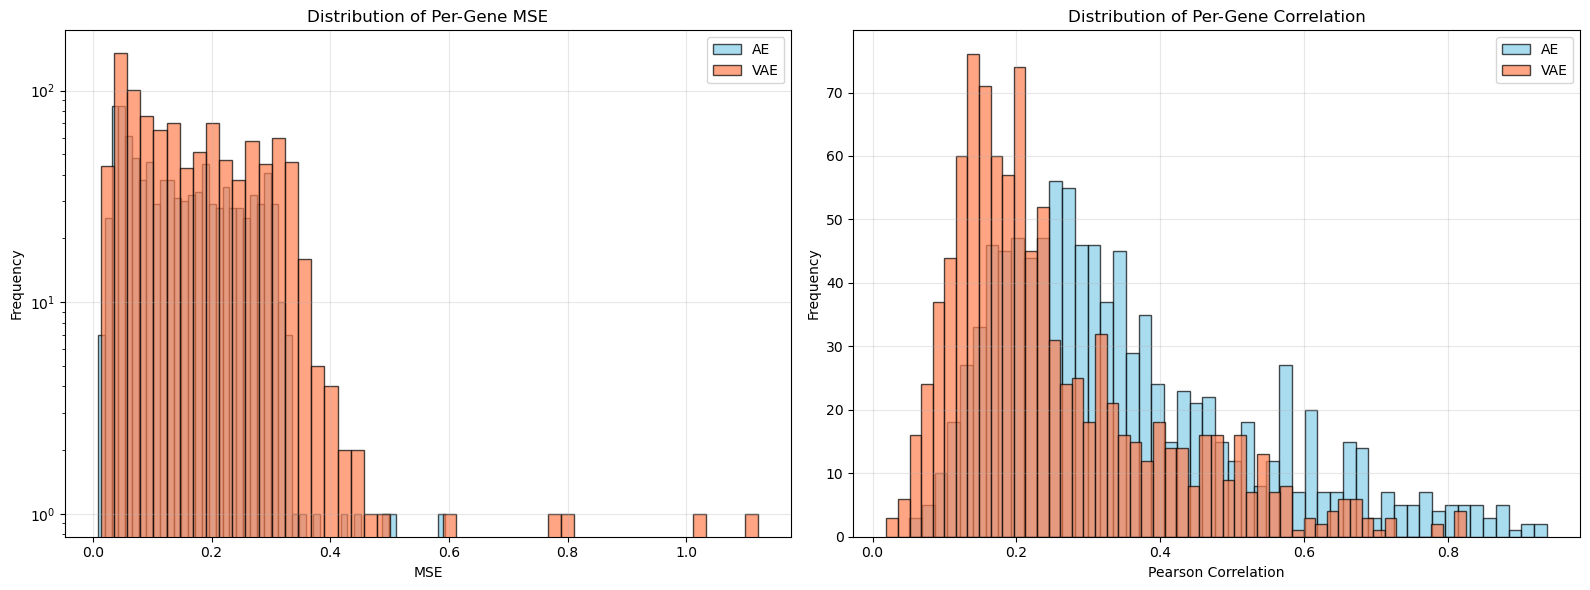


COMPREHENSIVE MODEL EVALUATION SUMMARY

Metric               AE                   VAE                 
------------------------------------------------------------
Overall MSE          0.1505               0.1676              
Overall MAE          0.2681               0.2842              
Mean Corr per gene   0.3521               0.2516              
Std Corr per gene    0.1818               0.1495              


In [14]:
# Re-evaluate loaded models to get fresh results
print("\n" + "="*60)
print("RE-EVALUATING LOADED MODELS")
print("="*60)

print("\nEvaluating Autoencoder...")
ae_results = evaluation.evaluate_model(autoencoder, test_loader, 'ae', scaler=scaler)

print("\nEvaluating VAE...")
vae_results = evaluation.evaluate_model(vae, test_loader, 'vae', scaler=scaler)

print("\n" + "="*60)
print("Evaluation complete! Results ready for visualization.")
print("="*60)

# Comprehensive reconstruction analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. MSE distribution comparison
axes[0].hist(ae_results['mse_per_gene'], bins=50, alpha=0.7, label='AE', color='skyblue', edgecolor='black')
axes[0].hist(vae_results['mse_per_gene'], bins=50, alpha=0.7, label='VAE', color='coral', edgecolor='black')
axes[0].set_title('Distribution of Per-Gene MSE')
axes[0].set_xlabel('MSE')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Correlation distribution comparison
axes[1].hist(ae_results['corr_per_gene'], bins=50, alpha=0.7, label='AE', color='skyblue', edgecolor='black')
axes[1].hist(vae_results['corr_per_gene'], bins=50, alpha=0.7, label='VAE', color='coral', edgecolor='black')
axes[1].set_title('Distribution of Per-Gene Correlation')
axes[1].set_xlabel('Pearson Correlation')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comprehensive summary (without R²)
print("\n" + "="*60)
print("COMPREHENSIVE MODEL EVALUATION SUMMARY")
print("="*60)
print(f"\n{'Metric':<20} {'AE':<20} {'VAE':<20}")
print("-"*60)
print(f"{'Overall MSE':<20} {ae_results['mse']:<20.4f} {vae_results['mse']:<20.4f}")
print(f"{'Overall MAE':<20} {ae_results['mae']:<20.4f} {vae_results['mae']:<20.4f}")
print(f"{'Mean Corr per gene':<20} {ae_results['corr_per_gene'].mean():<20.4f} {vae_results['corr_per_gene'].mean():<20.4f}")
print(f"{'Std Corr per gene':<20} {ae_results['corr_per_gene'].std():<20.4f} {vae_results['corr_per_gene'].std():<20.4f}")
print("="*60)